# Project 1

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings

In [2]:
np.set_printoptions(precision = 3)

plt.style.use("ggplot")

mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.color"] = "grey"
mpl.rcParams["grid.alpha"] = 0.25

mpl.rcParams["axes.facecolor"] = "white"

mpl.rcParams["legend.fontsize"] = 10

%matplotlib inline

warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("QF632_Project_1.csv")
df["Date"] = pd.to_datetime(df["Date"])

# Table of Contents

1. [Review Data Quality](#Review-Data-Quality)
2. [Check for Missing Value, Data Type Mismatches and Duplicate Records](#Check-for-Missing-Value-Data-Type-Mismatches-and-Duplicate-Records)
3. [Identify and Correct Errors](#Identify-and-Correct-Errors)
4. [Identify Outliers](#Identify-Outliers)
   1. [Z-score (Without Rolling Window)](#Z-score-Without-Rolling-Window)
   2. [Z-score (With Rolling Window)](#Z-score-With-Rolling-Window)
   3. [Isolation Forest (Without Rolling Window)](#Isolation-Forest-Without-Rolling-Window)
   4. [Isolation Forest (With Rolling Window = 200)](#Isolation-Forest-With-Rolling-Window-200)
5. [Interpolation by Using KNN Imputer](#Interpolation-by-Using-KNN-Imputer)
6. [Further Exploration](#Further-Exploration)
   1. [Correlation](#Correlation)
   2. [Time Lag Analysis](#Time-Lag-Analysis)
   3. [Rolling Correlation](#Rolling-Correlation)
   4. [Regression Analysis](#Regression-Analysis)


## Review Data Quality

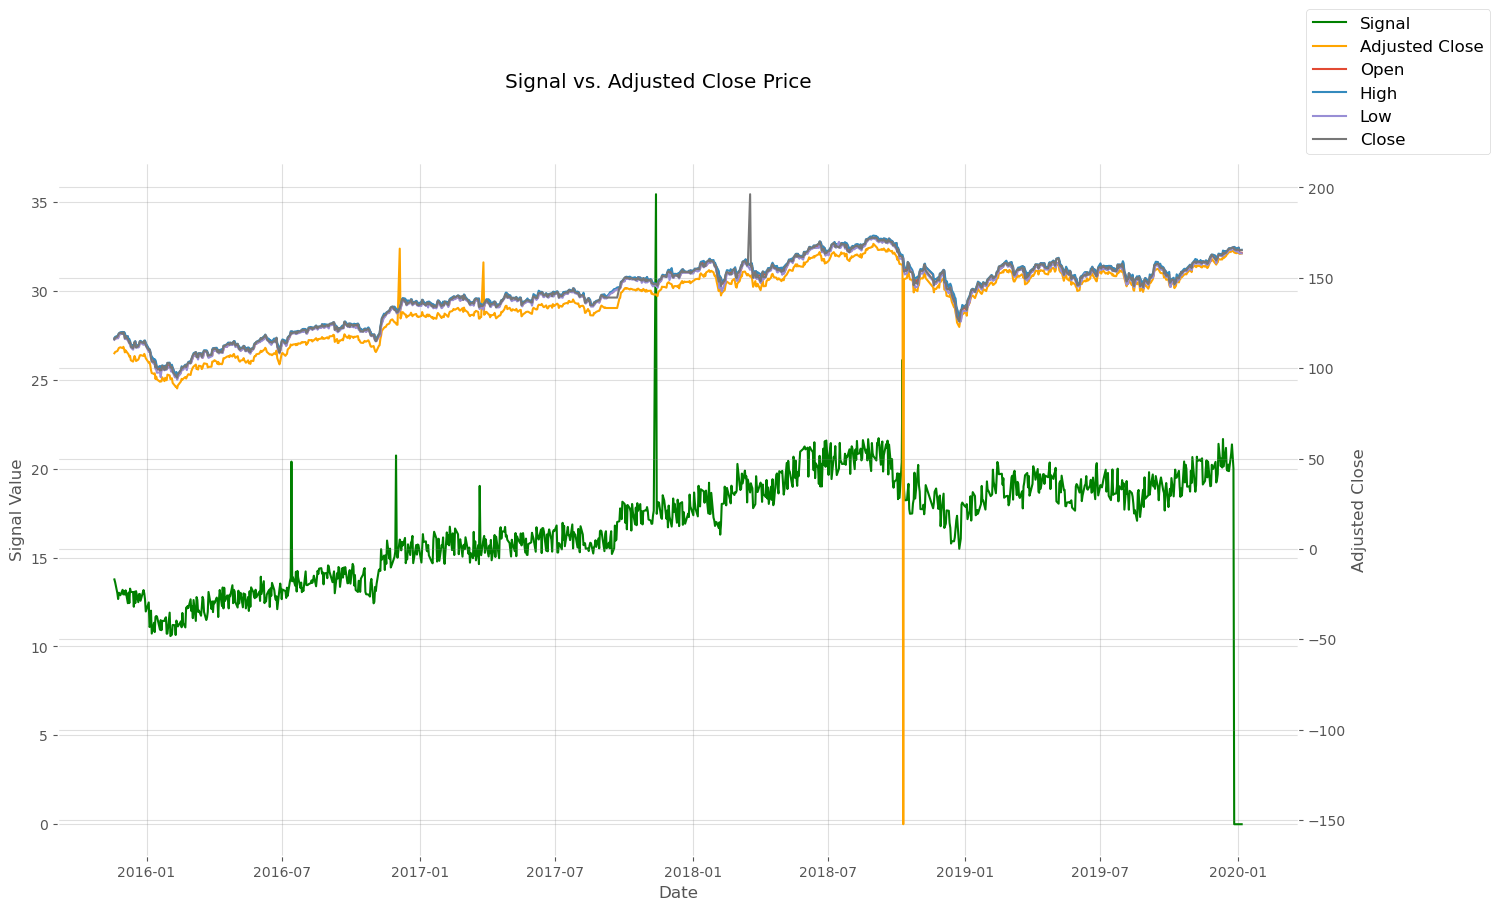

In [4]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(16, 9))

# Plot the Signal on the primary y-axis
ax1.plot(df['Date'], df['Signal'], label='Signal', color='g')
ax1.set_xlabel('Date', fontsize='large')  # Increase font size for x-axis label
ax1.set_ylabel('Signal Value', fontsize='large')  # Increase font size for y-axis label
ax1.tick_params(axis='y')

# Create a secondary y-axis and plot the Adjusted Close on it
ax2 = ax1.twinx()
ax2.plot(df['Date'], df['Adj Close'], label='Adjusted Close', color='orange')
ax2.plot(df['Date'], df['Open'], label='Open')
ax2.plot(df['Date'], df['High'], label='High')
ax2.plot(df['Date'], df['Low'], label='Low')
ax2.plot(df['Date'], df['Close'], label='Close')
ax2.set_ylabel('Adjusted Close', fontsize='large')  # Increase font size for y-axis label
ax2.tick_params(axis='y')

# Add a title and a legend with larger font size
fig.suptitle('Signal vs. Adjusted Close Price', fontsize='x-large')  # Increase font size for title
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower left', bbox_to_anchor=(1, 1), fontsize='large')
plt.show()


## Check for Missing Value, Data Type Mismatches and Duplicate Records

In [5]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values:\n", missing_values)

# Check data types
print("Data types before correction:\n", df.dtypes)

# Check for duplicate rows
duplicates = df.duplicated()
print("Duplicate rows:\n", df[duplicates])

Missing values:
 Date         0
Signal       0
Open         0
High         0
Low          0
Close        0
Adj Close    0
dtype: int64
Data types before correction:
 Date         datetime64[ns]
Signal              float64
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
dtype: object
Duplicate rows:
 Empty DataFrame
Columns: [Date, Signal, Open, High, Low, Close, Adj Close]
Index: []


## Identify and Correct Errors

In [6]:
# Check for values outside expected range
inconsistent_values = df[(df['Signal'] <= 0) | (df['Adj Close'] <= 0)]
print("Inconsistent values:\n", inconsistent_values)

Inconsistent values:
            Date     Signal        Open        High         Low       Close  \
732  2018-10-10  19.719477  160.820007  160.990005  156.360001  156.559998   
1032 2019-12-27   0.000000  167.119995  167.119995  165.429993  165.860001   
1033 2019-12-30   0.000000  165.979996  166.210007  164.570007  165.440002   
1034 2019-12-31   0.000000  165.080002  166.350006  164.710007  165.669998   
1035 2020-01-02   0.000000  166.740005  166.750000  164.229996  165.779999   
1036 2020-01-03   0.000000  163.740005  165.410004  163.699997  165.130005   
1037 2020-01-06   0.000000  163.850006  165.539993  163.539993  165.350006   

       Adj Close  
732  -152.277847  
1032  164.039063  
1033  163.623688  
1034  163.851135  
1035  163.959946  
1036  163.317093  
1037  163.534668  


In [7]:
# Correct the negative adjusted close price
df.at[732,"Adj Close"] = abs(df.at[732,"Adj Close"])

In [8]:
# Function to correct the high and low values
def correct_price_ranges(row):
    prices = {
        'Open': row['Open'],
        'High': row['High'],
        'Low': row['Low'],
        'Close': row['Close']
    }
    
    # Find the correct high and low values
    correct_high = max(prices.values())
    correct_low = min(prices.values())
    
    # Identify which keys (Open, High, Low, Close) have the max and min values
    max_key = next(key for key, value in prices.items() if value == correct_high)
    min_key = next(key for key, value in prices.items() if value == correct_low)
    
    # Check if the high and low values need to be corrected
    needs_correction = (row['High'] != correct_high) or (row['Low'] != correct_low)
    
    # Swap values to ensure high is max and low is min
    if needs_correction:
        for key in prices:
            if prices[key] == correct_high and key != 'High':
                prices[key], prices['High'] = prices['High'], prices[key]
        for key in prices:
            if prices[key] == correct_low and key != 'Low':
                prices[key], prices['Low'] = prices['Low'], prices[key]
    
    # Update the row with corrected values
    row['Open'] = prices['Open']
    row['High'] = prices['High']
    row['Low'] = prices['Low']
    row['Close'] = prices['Close']
    
    # Return the row and the correction flag
    return row, needs_correction

# Apply the correction function to each row in the DataFrame and track corrections
corrections = 0

def apply_correction(row):
    global corrections
    corrected_row, needs_correction = correct_price_ranges(row)
    if needs_correction:
        corrections += 1
    return corrected_row

df = df.apply(apply_correction, axis=1)

print(f"Number of rows that needed correction: {corrections}")

Number of rows that needed correction: 20


In [9]:
# Identify rows where High is less than Low
high_low_inconsistent = df[df['High'] < df['Low']]
print("Rows with inconsistent High and Low:\n", high_low_inconsistent)

# Swap High and Low values where High is less than Low
df.loc[df['High'] < df['Low'], ['High', 'Low']] = df.loc[df['High'] < df['Low'], ['Low', 'High']].values

# Verify the correction
high_low_inconsistent_after = df[df['High'] < df['Low']]
print("Rows with inconsistent High and Low after correction:\n", high_low_inconsistent_after)

Rows with inconsistent High and Low:
 Empty DataFrame
Columns: [Date, Signal, Open, High, Low, Close, Adj Close]
Index: []
Rows with inconsistent High and Low after correction:
 Empty DataFrame
Columns: [Date, Signal, Open, High, Low, Close, Adj Close]
Index: []


In [10]:
# Verify the Close price correction
inconsistent_data = df[(df['Close'] < df['Low']) | (df['Close'] > df['High'])]
print("Inconsistent data:\n", inconsistent_data)

df.loc[df['Close'] < df['Low'], 'Close'] = df['Low']
df.loc[df['Close'] > df['High'], 'Close'] = df['High']

# Verify the Close price correction
inconsistent_data_after = df[(df['Close'] < df['Low']) | (df['Close'] > df['High'])]
print("Inconsistent data after correction:\n", inconsistent_data_after)

Inconsistent data:
 Empty DataFrame
Columns: [Date, Signal, Open, High, Low, Close, Adj Close]
Index: []
Inconsistent data after correction:
 Empty DataFrame
Columns: [Date, Signal, Open, High, Low, Close, Adj Close]
Index: []


In [11]:
# Verify the Open price correction
inconsistent_data = df[(df['Open'] < df['Low']) | (df['Open'] > df['High'])]
print("Inconsistent data:\n", inconsistent_data)

df.loc[df['Open'] < df['Low'], 'Open'] = df['Low']
df.loc[df['Open'] > df['High'], 'Open'] = df['High']

# Verify the Open price correction
inconsistent_data_after = df[(df['Open'] < df['Low']) | (df['Open'] > df['High'])]
print("Inconsistent data after correction:\n", inconsistent_data_after)

Inconsistent data:
 Empty DataFrame
Columns: [Date, Signal, Open, High, Low, Close, Adj Close]
Index: []
Inconsistent data after correction:
 Empty DataFrame
Columns: [Date, Signal, Open, High, Low, Close, Adj Close]
Index: []


## Identify Outliers

### 1. Z-score (Without Rolling Window)

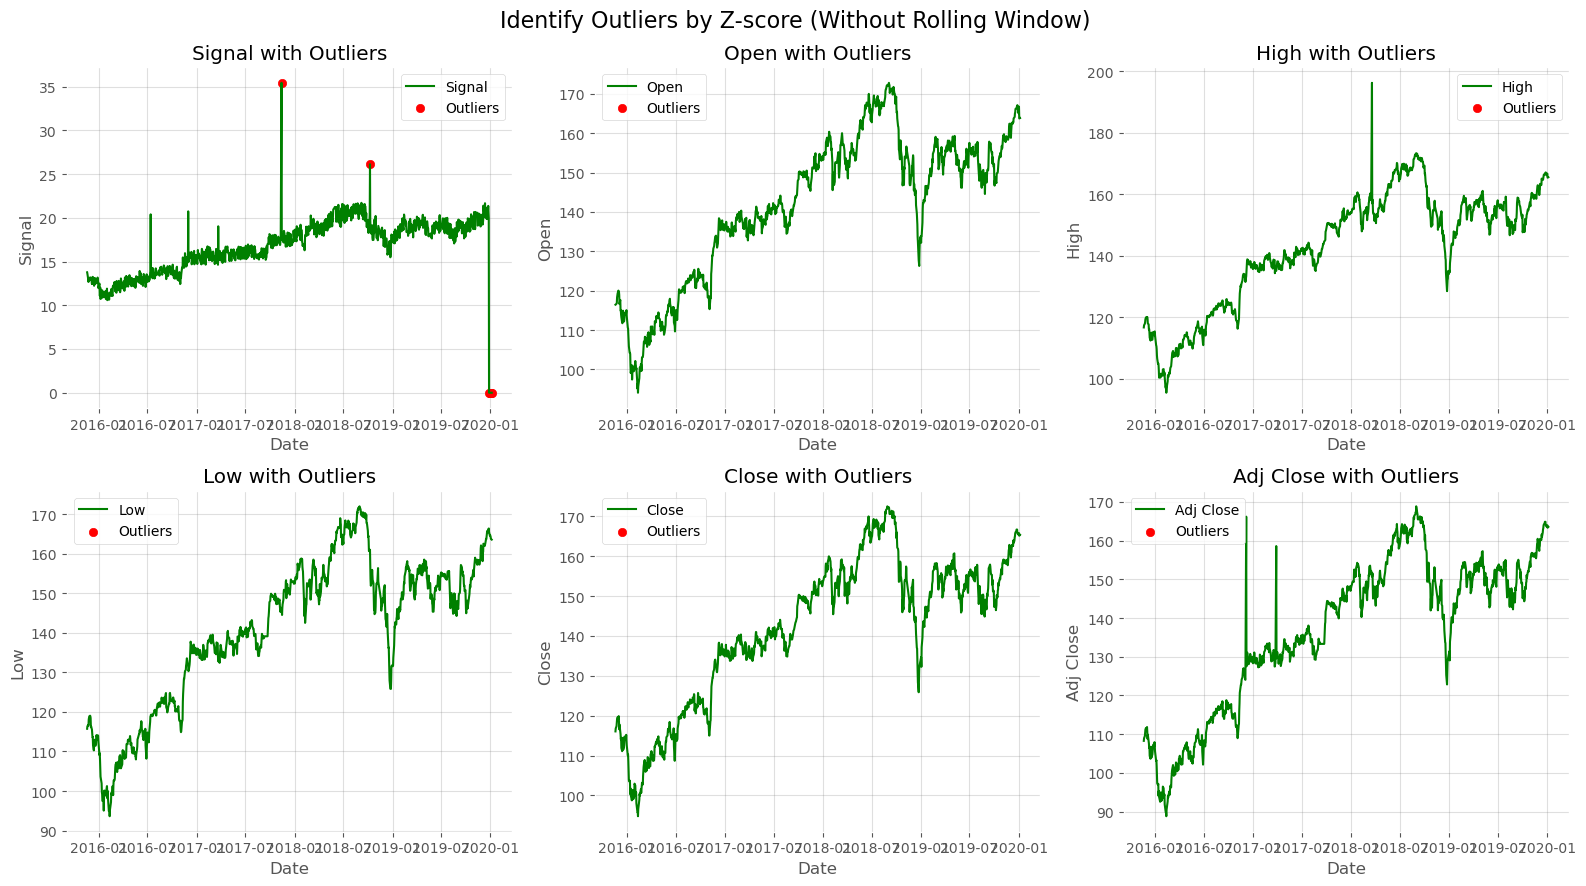

Number of outliers in column 'Signal': 8
Number of outliers in column 'Open': 0
Number of outliers in column 'High': 0
Number of outliers in column 'Low': 0
Number of outliers in column 'Close': 0
Number of outliers in column 'Adj Close': 0


In [12]:
from scipy import stats

def find_outliers_zscore(df, column, threshold=3):
    z_scores = stats.zscore(df[column])
    outliers = df[(z_scores > threshold) | (z_scores < -threshold)]
    return outliers

# Columns to check for outliers
columns_to_check = ['Signal', 'Open', 'High', 'Low', 'Close', 'Adj Close']
outliers_dict = {}

# Find outliers for each column and store them in a dictionary
for column in columns_to_check:
    outliers_dict[column] = find_outliers_zscore(df, column)

# Plotting each column with its outliers in a 3x2 grid
fig, axes = plt.subplots(2, 3, figsize=(16, 9))
fig.suptitle('Identify Outliers by Z-score (Without Rolling Window)', fontsize=16)
axes = axes.flatten()

for i, column in enumerate(columns_to_check):
    axes[i].plot(df['Date'], df[column], label=column, color='g')
    axes[i].scatter(outliers_dict[column]['Date'], outliers_dict[column][column], color='red', label='Outliers')
    axes[i].set_title(f'{column} with Outliers')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel(column)
    axes[i].legend()

plt.tight_layout()
plt.show()

# Print the count of outliers for each column
for column in columns_to_check:
    outliers_count = outliers_dict[column][column].count()
    print(f"Number of outliers in column '{column}': {outliers_count}")

#fig.savefig('outliers1.png')

### 2. Z-score (With Rolling Window)

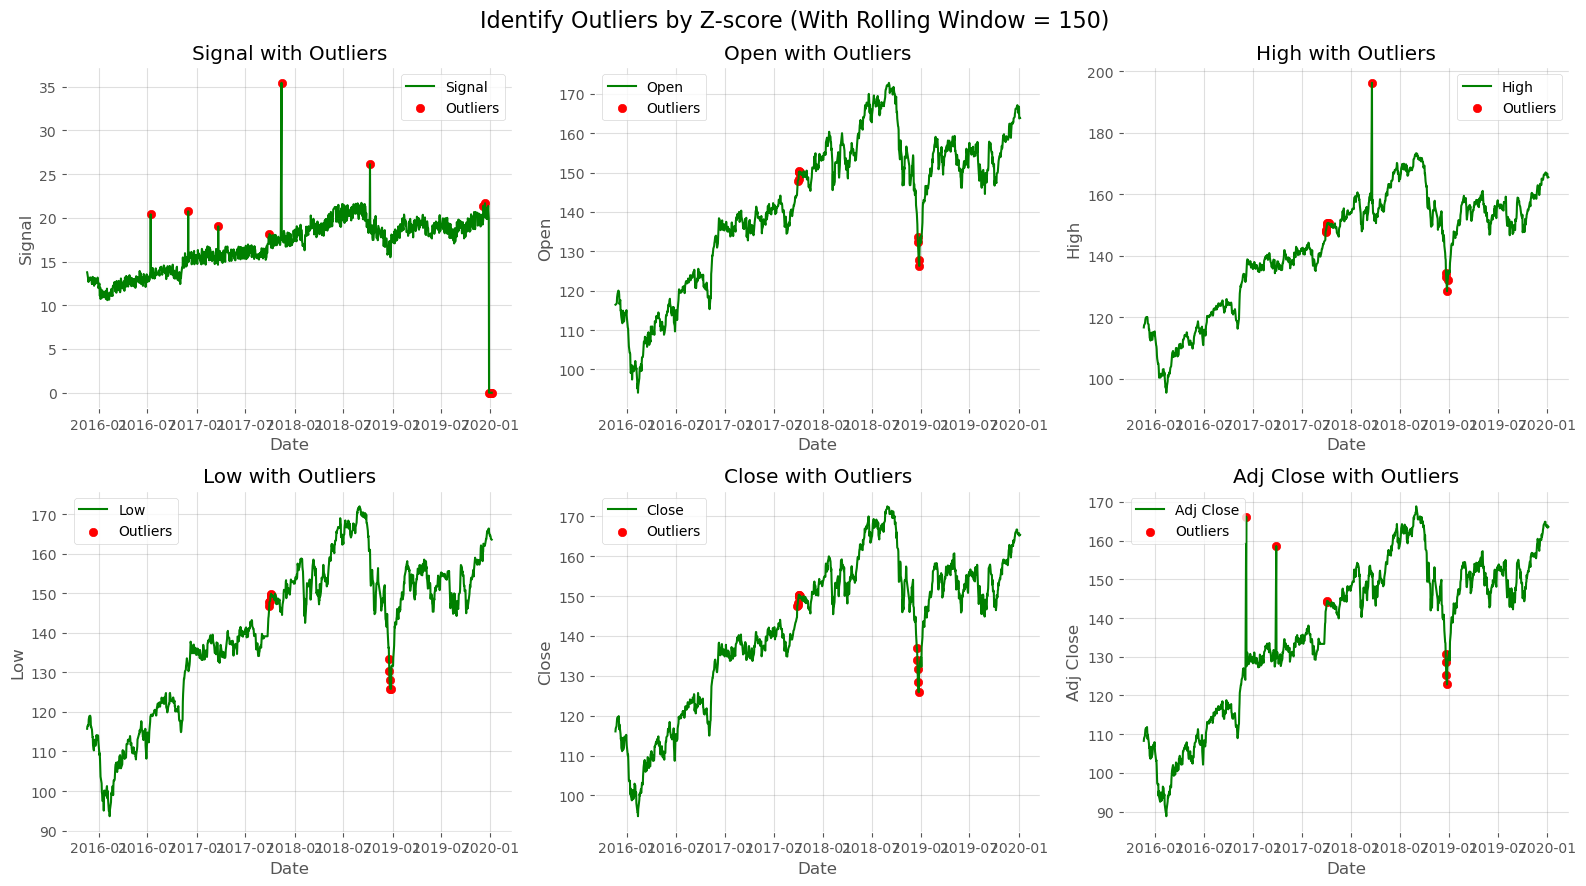

Number of outliers in column 'Signal': 14
Number of outliers in column 'Open': 10
Number of outliers in column 'High': 14
Number of outliers in column 'Low': 13
Number of outliers in column 'Close': 13
Number of outliers in column 'Adj Close': 8


In [13]:
def find_outliers_zscore_rolling(df, column, window=150, threshold=3):
    rolling_mean = df[column].rolling(window=window).mean()
    rolling_std = df[column].rolling(window=window).std()
    z_scores = (df[column] - rolling_mean) / rolling_std
    outliers = df[(z_scores > threshold) | (z_scores < -threshold)]
    return outliers

# Columns to check for outliers
columns_to_check = ['Signal', 'Open', 'High', 'Low', 'Close', 'Adj Close']
outliers_dict_rolling = {}

# Find outliers for each column and store them in a dictionary
for column in columns_to_check:
    outliers_dict_rolling[column] = find_outliers_zscore_rolling(df, column)

# Plotting each column with its outliers
fig, axes = plt.subplots(2, 3, figsize=(16, 9))
fig.suptitle('Identify Outliers by Z-score (With Rolling Window = 150)', fontsize=16)
axes = axes.flatten()

for i, column in enumerate(columns_to_check):
    axes[i].plot(df['Date'], df[column], label=column, color='g')
    axes[i].scatter(outliers_dict_rolling[column]['Date'], outliers_dict_rolling[column][column], color='red', label='Outliers')
    axes[i].set_title(f'{column} with Outliers')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel(column)
    axes[i].legend()

plt.tight_layout()
plt.show()

# Print the count of outliers for each column
for column in columns_to_check:
    outliers_count = outliers_dict_rolling[column][column].count()
    print(f"Number of outliers in column '{column}': {outliers_count}")

#fig.savefig('outliers2.png')

### 3. Isolation Forest (Without Rolling Window)

Processing Columns: 100%|█████████████████████████| 6/6 [00:02<00:00,  2.25it/s]


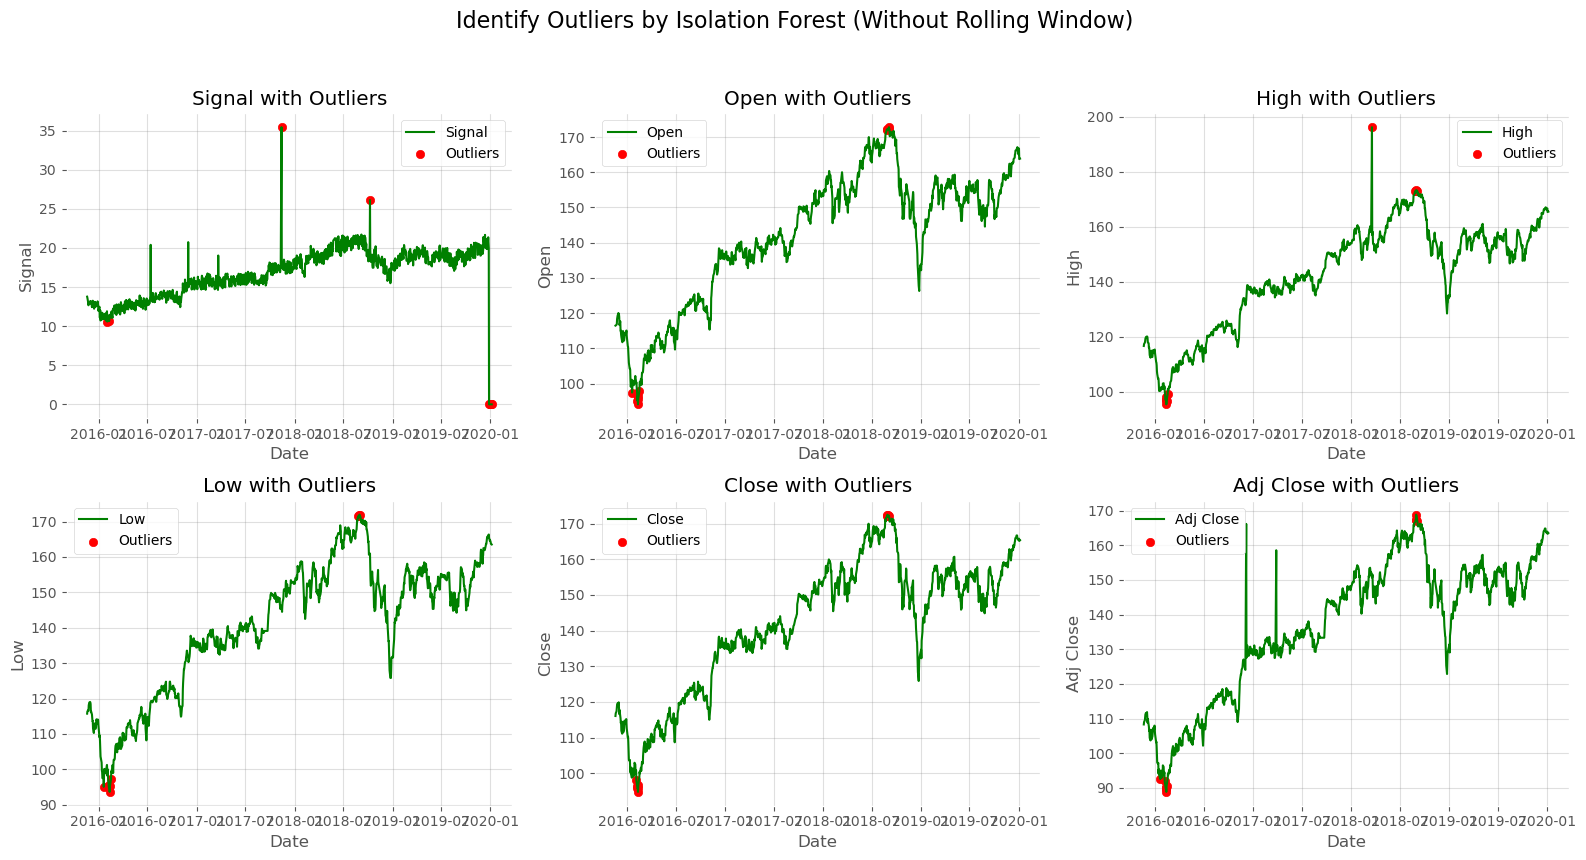

Number of outliers in column 'Signal': 11
Number of outliers in column 'Open': 11
Number of outliers in column 'High': 11
Number of outliers in column 'Low': 11
Number of outliers in column 'Close': 11
Number of outliers in column 'Adj Close': 11


In [14]:
from sklearn.ensemble import IsolationForest
from tqdm import tqdm

df1 = df.copy()

# Initialize IsolationForest
iso_forest = IsolationForest(n_estimators=500, contamination=0.01, random_state=42)

# Columns to check for outliers
columns_to_check = ['Signal', 'Open', 'High', 'Low', 'Close', 'Adj Close']
outliers_dict_iso = {}

# Find outliers for each column using IsolationForest and store them in a dictionary
for column in tqdm(columns_to_check, desc='Processing Columns'):
    df1[f'iso_f_outlier_{column}'] = iso_forest.fit_predict(df1[[column]])
    outliers_dict_iso[column] = df1[df1[f'iso_f_outlier_{column}'] == -1]

# Plotting each column with its outliers in a 3x2 grid
fig, axes = plt.subplots(2, 3, figsize=(16, 9))
fig.suptitle('Identify Outliers by Isolation Forest (Without Rolling Window)', fontsize=16)
axes = axes.flatten()

for i, column in enumerate(columns_to_check):
    axes[i].plot(df1['Date'], df1[column], label=column, color='g')
    axes[i].scatter(outliers_dict_iso[column]['Date'], outliers_dict_iso[column][column], color='red', label='Outliers')
    axes[i].set_title(f'{column} with Outliers')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel(column)
    axes[i].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Print the count of outliers for each column
for column in columns_to_check:
    outliers_count = outliers_dict_iso[column][column].count()
    print(f"Number of outliers in column '{column}': {outliers_count}")

#fig.savefig('outliers3.png')

### 4. Isolation Forest (With Rolling Window = 200)

Processing Windows: 100%|█████████████████████| 839/839 [05:52<00:00,  2.38it/s]


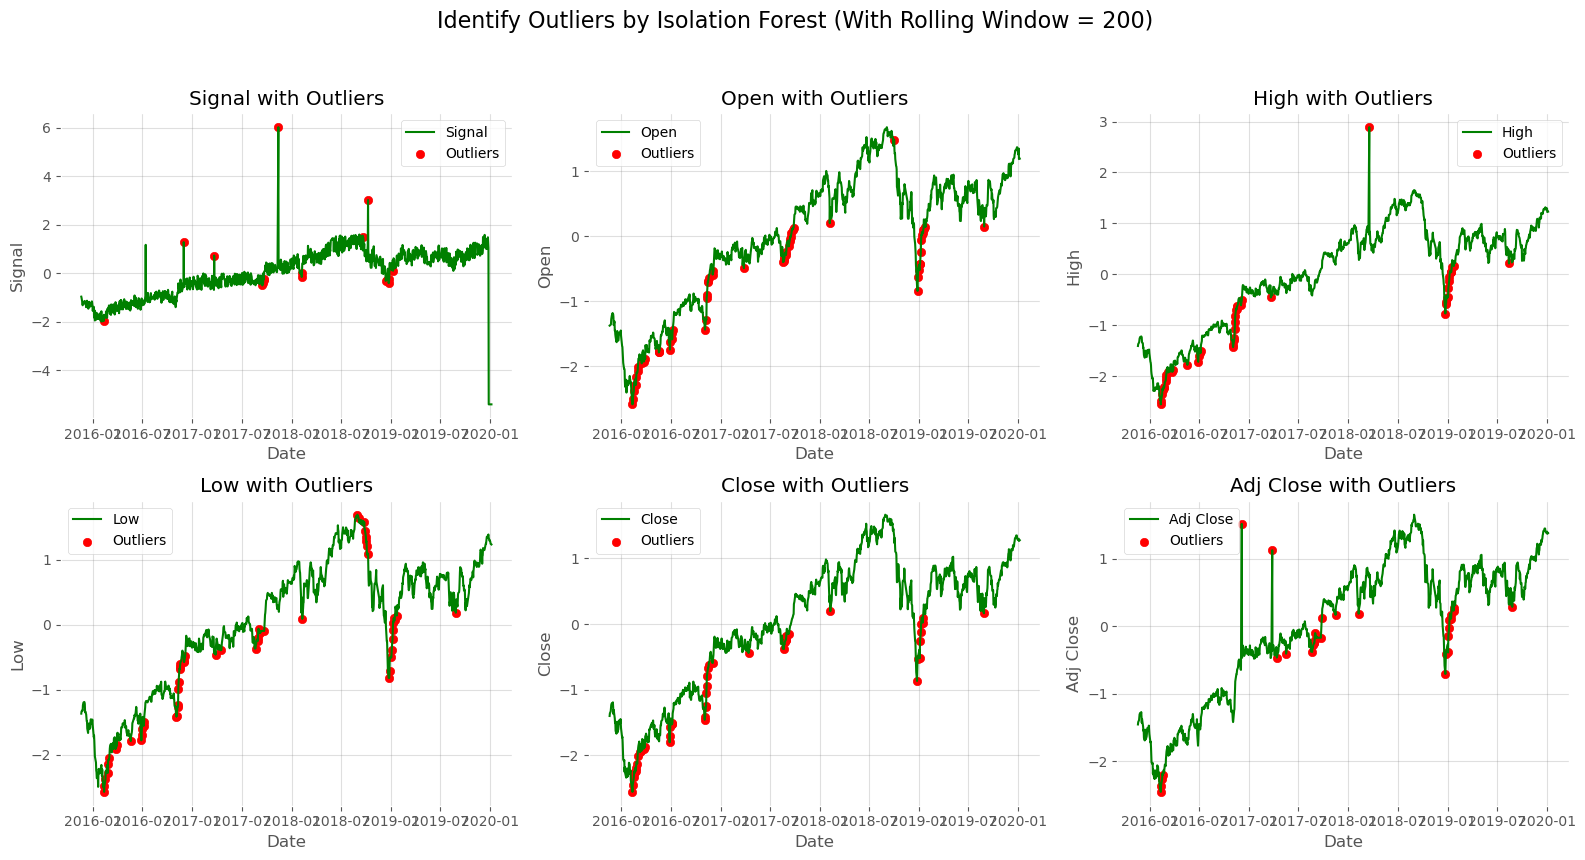

Number of outliers in column 'Signal': 18
Number of outliers in column 'Open': 57
Number of outliers in column 'High': 45
Number of outliers in column 'Low': 54
Number of outliers in column 'Close': 47
Number of outliers in column 'Adj Close': 30


In [15]:
from sklearn.preprocessing import StandardScaler

df2 = df.copy()

# Standardize the data
scaler = StandardScaler()
df2[['Close', 'Adj Close', 'Signal', 'Open', 'High', 'Low']] = scaler.fit_transform(
    df2[['Close', 'Adj Close', 'Signal', 'Open', 'High', 'Low']])

# Initialize parameters
window_size = 200  # day
columns_to_check = ['Signal', 'Open', 'High', 'Low', 'Close', 'Adj Close']
contamination_rate = {'Close': 0.002, 'Adj Close': 0.002, 'Signal': 0.008, 'Open': 0.002, 'High': 0.002, 'Low': 0.002}

# Initialize outlier columns
for column in columns_to_check:
    df2[f'iso_f_outlier_{column}'] = 1

total_windows = len(df2) - window_size + 1

# Process each window
for start in tqdm(range(0, total_windows), desc='Processing Windows'):
    end = start + window_size
    window_data = df.iloc[start:end]

    for column in columns_to_check:
        iso_forest = IsolationForest(n_estimators=100, contamination=contamination_rate[column], random_state=42)
        outliers_pred = iso_forest.fit_predict(window_data[[column]])
        df2.loc[window_data.index, f'iso_f_outlier_{column}'] = outliers_pred

# Replace outlier labels
df2.replace({-1: 1, 1: 0}, inplace=True)

# Extract outliers for each column
outliers_dict_iso_rolling = {column: df2[df2[f'iso_f_outlier_{column}'] == 1] for column in columns_to_check}

# Plotting each column with its outliers in a 3x2 grid
fig, axes = plt.subplots(2, 3, figsize=(16, 9))
fig.suptitle('Identify Outliers by Isolation Forest (With Rolling Window = 200)', fontsize=16)
axes = axes.flatten()

for i, column in enumerate(columns_to_check):
    axes[i].plot(df2['Date'], df2[column], label=column, color='g')
    axes[i].scatter(outliers_dict_iso_rolling[column]['Date'], outliers_dict_iso_rolling[column][column], color='red', label='Outliers')
    axes[i].set_title(f'{column} with Outliers')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel(column)
    axes[i].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Print the count of outliers for each column
for column in columns_to_check:
    outliers_count = outliers_dict_iso_rolling[column][column].count()
    print(f"Number of outliers in column '{column}': {outliers_count}")

#fig.savefig('outliers4.png')

## Interpolation by Using KNN Imputer

In [16]:
data_trans = df.copy()

for column in columns_to_check:
    row_indexer = outliers_dict_rolling[column].index
    data_trans.loc[row_indexer, column] = None

In [17]:
data_trans.isna().sum()

Date          0
Signal       14
Open         10
High         14
Low          13
Close        13
Adj Close     8
dtype: int64

In [18]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5, weights='uniform')
data_trans[columns_to_check] = imputer.fit_transform(data_trans[columns_to_check])

In [19]:
data_trans.tail(10)

,Date,Signal,Open,High,Low,Close,Adj Close
1028,2019-12-20,19.858758,166.149994,166.410004,165.720001,165.970001,164.147858
1029,2019-12-23,20.855705,166.240005,166.360001,165.360001,166.300003,164.474243
1030,2019-12-24,21.361876,166.449997,166.699997,166.039993,166.679993,164.850052
1031,2019-12-26,20.016643,166.830002,166.979996,166.360001,166.679993,164.850052
1032,2019-12-27,20.463374,167.119995,167.119995,165.429993,165.860001,164.039063
1033,2019-12-30,20.451597,165.979996,166.210007,164.570007,165.440002,163.623688
1034,2019-12-31,20.436352,165.080002,166.350006,164.710007,165.669998,163.851135
1035,2020-01-02,20.436352,166.740005,166.750000,164.229996,165.779999,163.959946
1036,2020-01-03,19.906968,163.740005,165.410004,163.699997,165.130005,163.317093
1037,2020-01-06,19.906968,163.850006,165.539993,163.539993,165.350006,163.534668


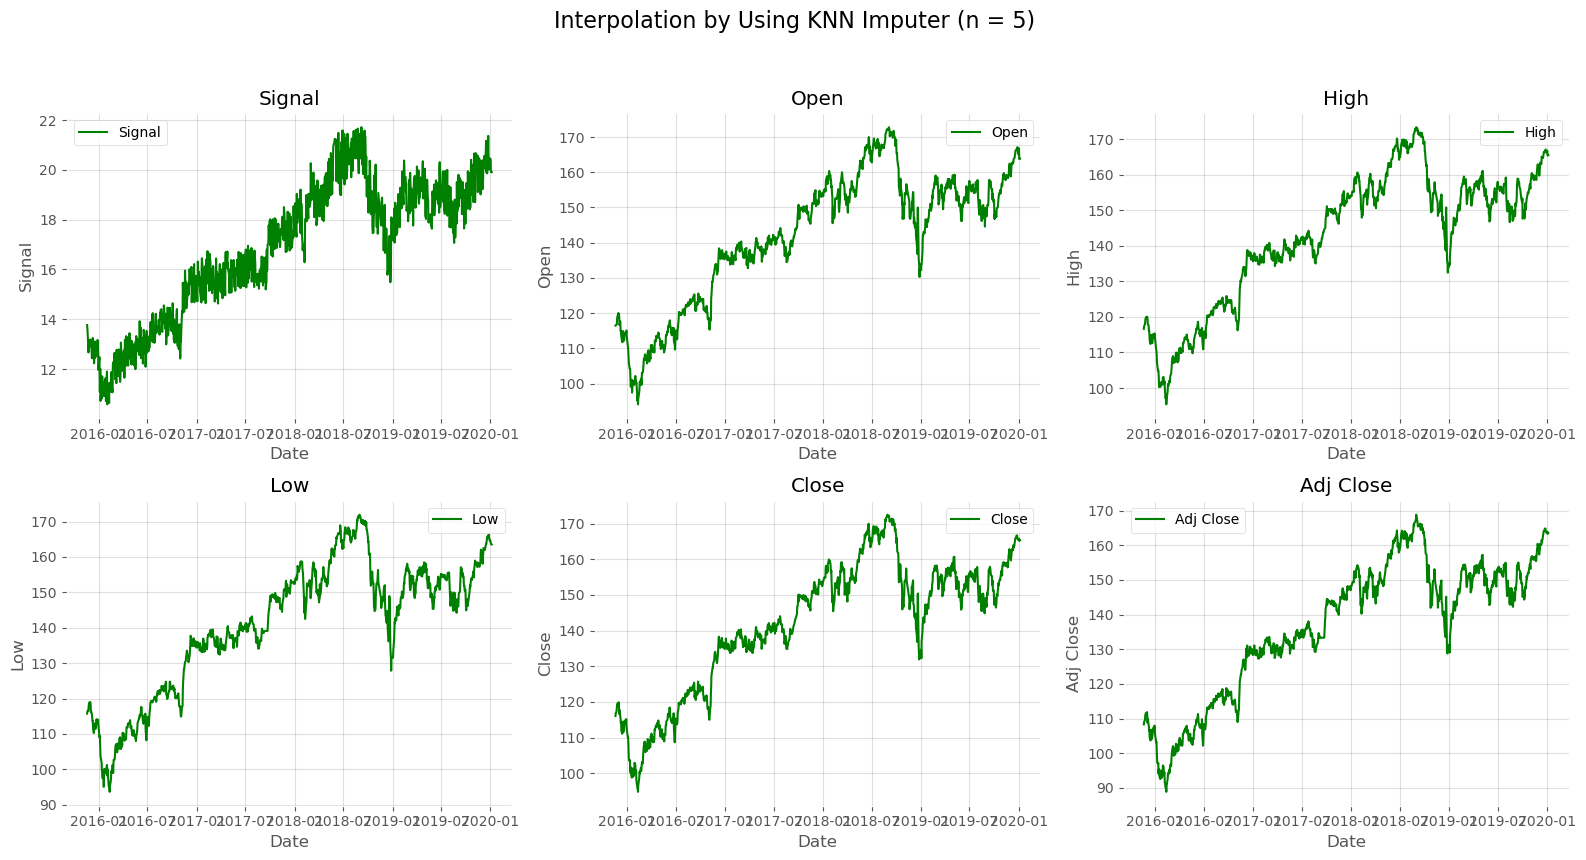

In [20]:
# Plotting each column with its outliers in a 3x2 grid
fig, axes = plt.subplots(2, 3, figsize=(16, 9))
fig.suptitle('Interpolation by Using KNN Imputer (n = 5)', fontsize=16)
axes = axes.flatten()

for i, column in enumerate(columns_to_check):
    axes[i].plot(data_trans['Date'], data_trans[column], label=column, color='g')
    axes[i].set_title(f'{column}')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel(column)
    axes[i].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

#fig.savefig('done.png')

## Further Exploration

### 1. Correlation

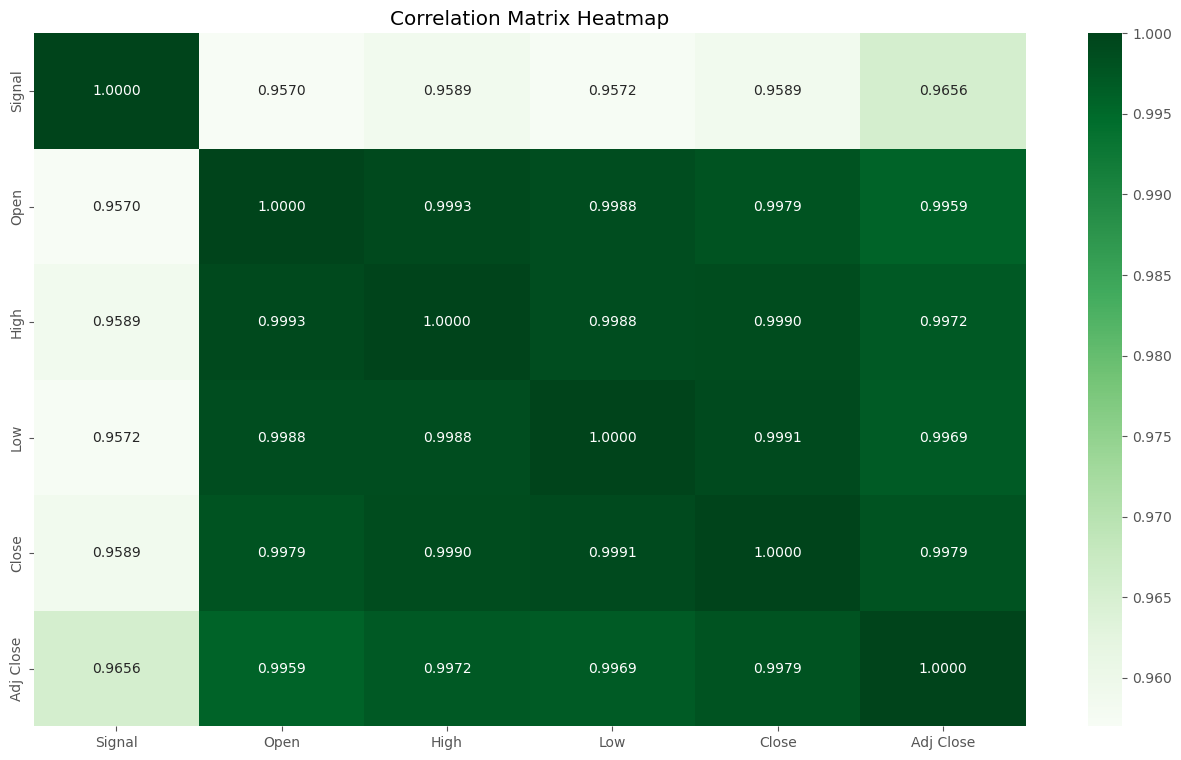

In [21]:
correlation_matrix = data_trans.drop(columns='Date').corr()

plt.figure(figsize=(16, 9))
sns.heatmap(correlation_matrix, annot=True, cmap='Greens', fmt='.4f')
plt.title('Correlation Matrix Heatmap')
plt.show()

#fig.savefig('correlation.png')

### 2. Time Lag Analysis

In [22]:
data_trans1 = data_trans.copy()

In [23]:
# Create lagged signal columns
data_trans1['Signal_Lag1'] = data_trans1['Signal'].shift(1)
data_trans1['Signal_Lag2'] = data_trans1['Signal'].shift(2)
data_trans1['Signal_Lag3'] = data_trans1['Signal'].shift(3)

# Calculate correlation with different lags
correlation_lag1 = data_trans1['Signal_Lag1'].corr(data_trans1['Adj Close'])
correlation_lag2 = data_trans1['Signal_Lag2'].corr(data_trans1['Adj Close'])
correlation_lag3 = data_trans1['Signal_Lag3'].corr(data_trans1['Adj Close'])

print(f"Correlation with 1-day lag: {correlation_lag1}")
print(f"Correlation with 2-day lag: {correlation_lag2}")
print(f"Correlation with 3-day lag: {correlation_lag3}")

Correlation with 1-day lag: 0.9675207617702843
Correlation with 2-day lag: 0.9698997390421007
Correlation with 3-day lag: 0.9714413504526396


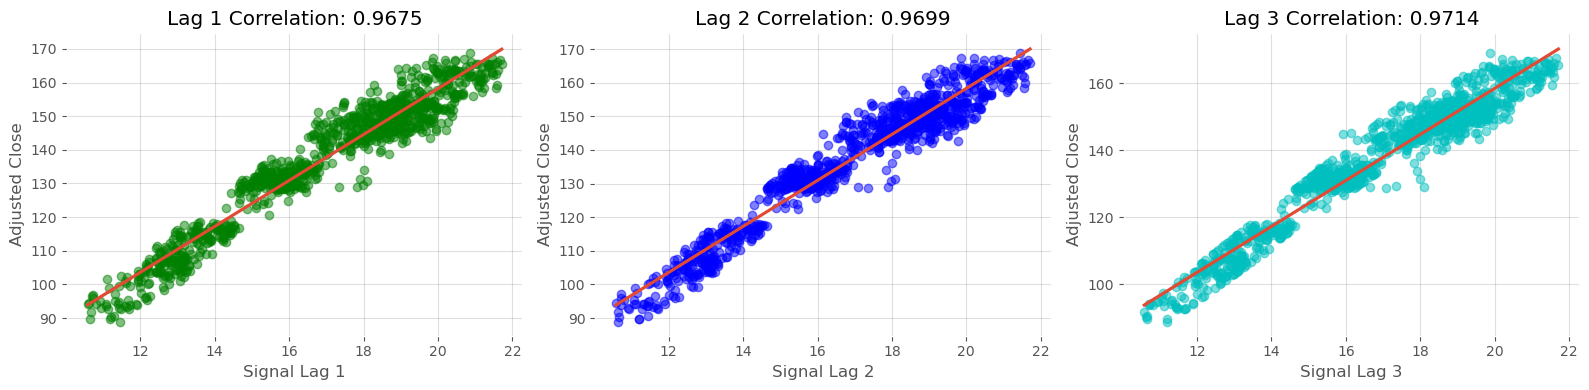

In [24]:
plt.figure(figsize=(16, 4))

plt.subplot(1, 3, 1)
sns.regplot(x='Signal_Lag1', y='Adj Close', data=data_trans1, scatter_kws={'alpha':0.5, 'color':'g'})
plt.xlabel('Signal Lag 1')
plt.ylabel('Adjusted Close')
plt.title(f'Lag 1 Correlation: {correlation_lag1:.4f}')

plt.subplot(1, 3, 2)
sns.regplot(x='Signal_Lag2', y='Adj Close', data=data_trans1, scatter_kws={'alpha':0.5, 'color':'b'})
plt.xlabel('Signal Lag 2')
plt.ylabel('Adjusted Close')
plt.title(f'Lag 2 Correlation: {correlation_lag2:.4f}')

plt.subplot(1, 3, 3)
sns.regplot(x='Signal_Lag3', y='Adj Close', data=data_trans1, scatter_kws={'alpha':0.5, 'color':'c'})
plt.xlabel('Signal Lag 3')
plt.ylabel('Adjusted Close')
plt.title(f'Lag 3 Correlation: {correlation_lag3:.4f}')

plt.tight_layout()
plt.show()

#### Determine the Optimal Lag

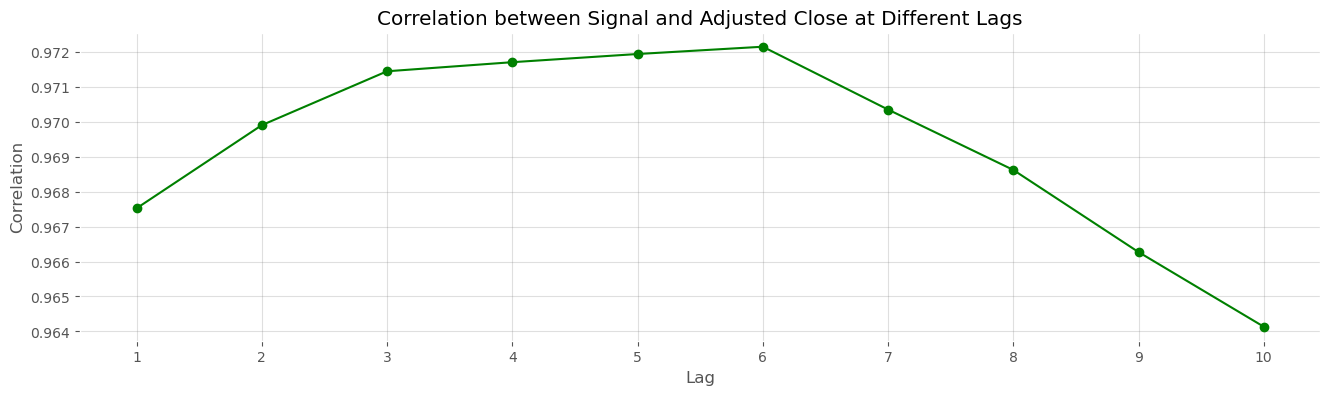

In [25]:
def calculate_lag_correlations(data_trans1, max_lag):
    correlations = []
    for lag in range(1, max_lag + 1):
        data_trans1[f'Signal_Lag{lag}'] = data_trans1['Signal'].shift(lag)
        correlation = data_trans1[f'Signal_Lag{lag}'].corr(data_trans1['Adj Close'])
        correlations.append(correlation)
    return correlations

# Calculate correlations for lags from 1 to 10
max_lag = 10
correlations = calculate_lag_correlations(data_trans1, max_lag)

# Plot correlation vs lag
plt.figure(figsize=(16, 4))
plt.plot(range(1, max_lag + 1), correlations, marker='o', color ='g')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.title('Correlation between Signal and Adjusted Close at Different Lags')
plt.xticks(range(1, max_lag + 1))
plt.grid(True)
plt.show()

#fig.savefig('different_lag.png')

###  3. Rolling Correlation:

#### Orgininal Data

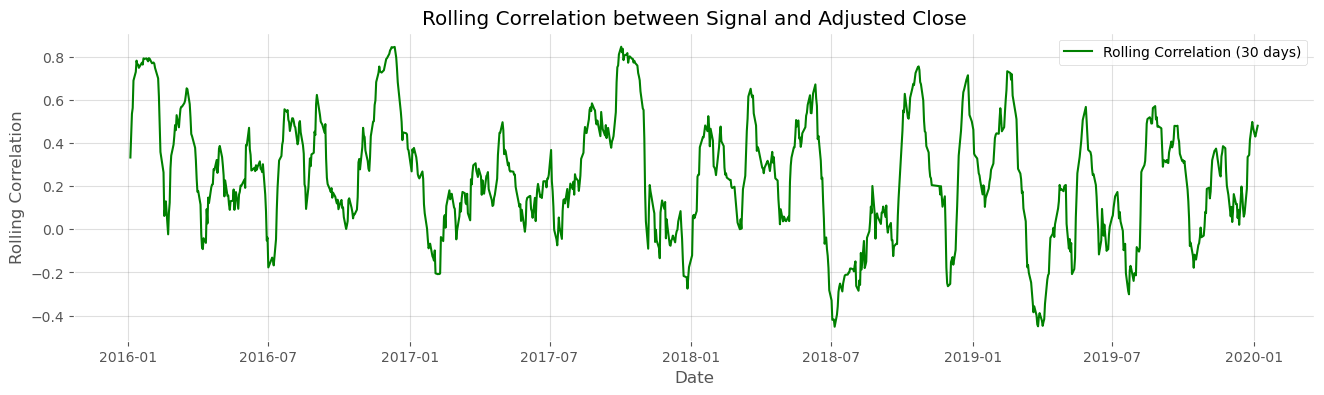

In [26]:
# Calculate rolling correlation
data_trans1['Rolling_Corr'] = data_trans1['Signal'].rolling(window=30).corr(data_trans1['Adj Close'])

# Plot rolling correlation
plt.figure(figsize=(16, 4))
plt.plot(data_trans1['Date'], data_trans1['Rolling_Corr'], label='Rolling Correlation (30 days)', color = 'g')
plt.xlabel('Date')
plt.ylabel('Rolling Correlation')
plt.title('Rolling Correlation between Signal and Adjusted Close')
plt.legend()
plt.show()

#### Lag 5

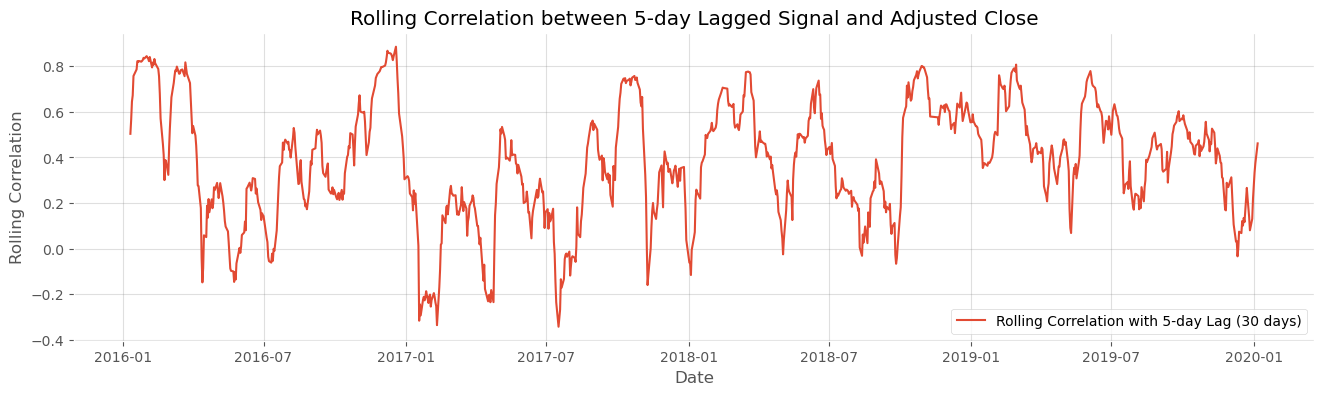

In [27]:
data_trans1['Signal_Lag5'] = data_trans1['Signal'].shift(5)
data_trans1['Rolling_Corr_Lag5'] = data_trans1['Signal_Lag5'].rolling(window=30).corr(data_trans1['Adj Close'])

plt.figure(figsize=(16, 4))
plt.plot(data_trans1['Date'], data_trans1['Rolling_Corr_Lag5'], label='Rolling Correlation with 5-day Lag (30 days)')
plt.xlabel('Date')
plt.ylabel('Rolling Correlation')
plt.title('Rolling Correlation between 5-day Lagged Signal and Adjusted Close')
plt.legend()
plt.show()

#### Comparison

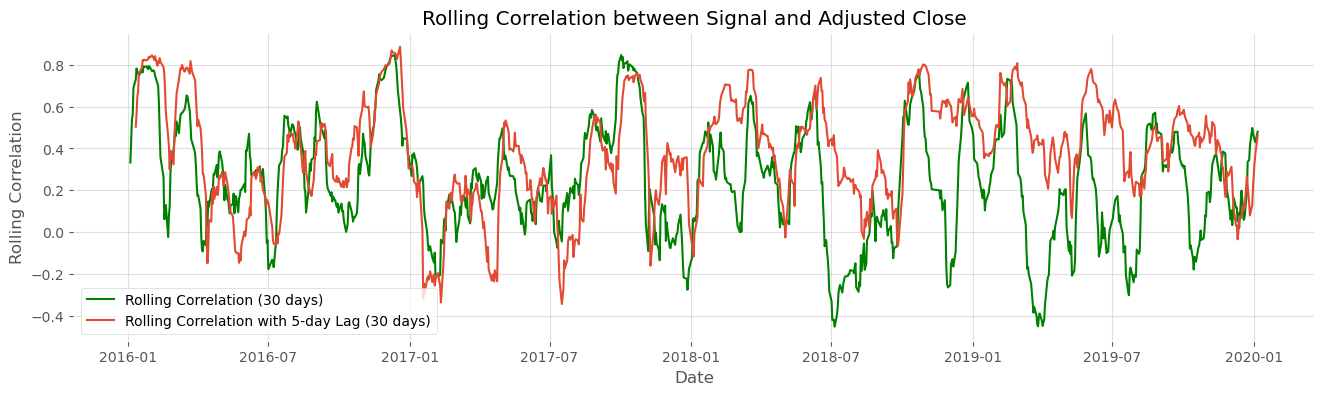

In [28]:
plt.figure(figsize=(16, 4))

# Plot rolling correlation with original signal
plt.plot(data_trans1['Date'], data_trans1['Rolling_Corr'], label='Rolling Correlation (30 days)', color = 'g')

# Plot rolling correlation with 5-day lagged signal
plt.plot(data_trans1['Date'], data_trans1['Rolling_Corr_Lag5'], label='Rolling Correlation with 5-day Lag (30 days)')

plt.xlabel('Date')
plt.ylabel('Rolling Correlation')
plt.title('Rolling Correlation between Signal and Adjusted Close')
plt.legend()
plt.show()

#fig.savefig('lag5.png')

In [29]:
# Calculate summary statistics
original_mean = data_trans1['Rolling_Corr'].mean()
original_std = data_trans1['Rolling_Corr'].std()

lagged_mean = data_trans1['Rolling_Corr_Lag5'].mean()
lagged_std = data_trans1['Rolling_Corr_Lag5'].std()

print(f"Original Signal - Mean: {original_mean:.2f}, Std: {original_std:.2f}")
print(f"Lagged Signal (5 days) - Mean: {lagged_mean:.2f}, Std: {lagged_std:.2f}")


Original Signal - Mean: 0.24, Std: 0.28
Lagged Signal (5 days) - Mean: 0.38, Std: 0.26


### 4. Regression Analysis:

#### Original Data

In [30]:
import statsmodels.api as sm

# Prepare the data for regression
X = data_trans1['Signal']
y = data_trans1['Adj Close']
X = sm.add_constant(X)  # Adds a constant term to the predictor

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the summary of the regression
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              Adj Close   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                 1.427e+04
Date:                Mon, 03 Jun 2024   Prob (F-statistic):               0.00
Time:                        02:14:56   Log-Likelihood:                -3154.3
No. Observations:                1038   AIC:                             6313.
Df Residuals:                    1036   BIC:                             6323.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         21.7657      0.974     22.343      0.0

#### Lag 5

In [31]:
# Create the 5-day lagged signal column
data_trans1['Signal_Lag5'] = data_trans1['Signal'].shift(5)

# Drop rows with NaN values generated by the lag
data_trans1 = data_trans1.dropna(subset=['Signal_Lag5'])

# Prepare the data for regression
X = data_trans1['Signal_Lag5']
y = data_trans1['Adj Close']
X = sm.add_constant(X)  # Adds a constant term to the predictor

# Fit the regression model
model_lagged = sm.OLS(y, X).fit()

# Print the summary of the regression
print(model_lagged.summary())

                            OLS Regression Results                            
Dep. Variable:              Adj Close   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                 1.760e+04
Date:                Mon, 03 Jun 2024   Prob (F-statistic):               0.00
Time:                        02:14:56   Log-Likelihood:                -3032.8
No. Observations:                1033   AIC:                             6070.
Df Residuals:                    1031   BIC:                             6079.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          21.3651      0.881     24.244      